# Generating heatmap for the chemotaxonomy

### Import modules

In [1]:
import os
import string
from ast import literal_eval

import pandas as pd
import numpy as np
from tqdm import tqdm

# Import taxonomy
from utils import get_genus_and_family_info_for_plants
from ete3 import NCBITaxa

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import chisquare
from utils import create_genus_compound_vectors, create_taxon_compound_vectors

In [2]:
sns.set_style("whitegrid")
mpl.rcParams['figure.dpi'] = 360
%matplotlib inline

In [3]:
tqdm.pandas()
pd.set_option('display.max_columns', None)

### Load chemicals

In [4]:
plant_chemical_df = pd.read_csv(
    's3://enveda-datascience/daniel_domingo/plant_chemical_associations.tsv.gz',
    compression='gzip',
    sep='\t',
    usecols=[
        'plant_curie',
        'chemical_curie',
    ]
)

In [5]:
plant_chemical_df.head(1)

,plant_curie,chemical_curie
0,ncbitaxon:1000425,pubchem.compound:3527


In [6]:
len(plant_chemical_df.chemical_curie.unique())

87019

In [7]:
if os.path.exists('../data/specie_chemical_counts.tsv'):
    specie_chemical_vectors = pd.read_csv('../data/specie_chemical_counts.tsv', sep='\t')
else:
    specie_chemical_vectors = create_genus_compound_vectors(plant_chemical_df)
    specie_chemical_vectors.to_csv('../data/specie_chemical_counts.tsv', sep='\t', index=False)

In [8]:
specie_chemical_vectors.head(2)

,plant_name,# chemicals,# chemicals in plant only
0,ncbitaxon:489341,35,17
1,ncbitaxon:174247,9,0


## Generating family chemical space vectors

In [9]:
plant_disease_df = pd.read_csv(
    's3://enveda-datascience/daniel_domingo/plant_disease_associations.tsv.gz',
    compression='gzip',
    sep='\t',
    usecols=[
        'plant_curie',
        'disease_curie',
    ]
)

In [10]:
medicinal_plants = set(plant_disease_df.plant_curie.unique())

In [11]:
if os.path.exists('../data/family_chemical_count.tsv'):
    family_df = pd.read_csv('../data/family_chemical_count.tsv', sep='\t')
else:
    genus_to_species, family_to_species = get_genus_and_family_info_for_plants(
        set(plant_chemical_df.plant_curie.unique())
    )
    family_df = create_taxon_compound_vectors(family_to_species, plant_chemical_df, med_plants=medicinal_plants)
    family_df.to_csv('../data/family_chemical_count.tsv', sep='\t', index=False)
    

In [12]:
family_df.head(2)

,family,# chemicals,# family specific chemicals,# med plants,# plants in fam,plants in fam
0,ncbitaxon:3536,243,59,5,15,"['ncbitaxon:122400', 'ncbitaxon:427792', 'ncbi..."
1,ncbitaxon:4037,4652,1487,105,436,"['ncbitaxon:692015', 'ncbitaxon:1534653', 'ncb..."


In [13]:
if os.path.exists('../data/genus_chemical_count.tsv'):
    genus_df = pd.read_csv('../data/genus_chemical_count.tsv', sep='\t')
else:
    genus_to_species, family_to_species = get_genus_and_family_info_for_plants(
        set(plant_chemical_df.plant_curie.unique())
    )
    genus_df = create_taxon_compound_vectors(genus_to_species, plant_chemical_df, med_plants=medicinal_plants)
    genus_df.to_csv('../data/genus_chemical_count.tsv', sep='\t', index=False)

In [14]:
genus_df.head(2)

,family,# chemicals,# family specific chemicals,# med plants,# plants in fam,plants in fam
0,ncbitaxon:41615,4,0,0,1,['ncbitaxon:882374']
1,ncbitaxon:1288172,1,0,0,1,['ncbitaxon:1288173']


# Mapping families to their names

In [15]:
ncbi = NCBITaxa()

In [16]:
ncbitaxon_to_name = {
    idx: ncbi.get_taxid_translator([int(idx.split(':')[1])])[int(idx.split(':')[1])]
    for idx in family_df.family.unique()
}

In [17]:
family_df['fam_name'] = family_df.family.map(ncbitaxon_to_name)
family_df.head(2)

,family,# chemicals,# family specific chemicals,# med plants,# plants in fam,plants in fam,fam_name
0,ncbitaxon:3536,243,59,5,15,"['ncbitaxon:122400', 'ncbitaxon:427792', 'ncbi...",Nyctaginaceae
1,ncbitaxon:4037,4652,1487,105,436,"['ncbitaxon:692015', 'ncbitaxon:1534653', 'ncb...",Apiaceae


In [18]:
family_df.set_index('fam_name', inplace=True)
family_df.drop(columns=['family'], inplace=True)

## Annotating stats

In [19]:
# Calculate average of chemicals per species
fam_average_chemicals_per_species = family_df['# chemicals'].sum() / family_df['# plants in fam'].sum()
genus_average_chemicals_per_species = genus_df['# chemicals'].sum() / genus_df['# plants in fam'].sum()

proportion_medicinal_plants = family_df['# med plants'].sum() / family_df['# plants in fam'].sum()

# Expected number of specific chemicals per species
fam_average_specific_chemicals_per_species = family_df['# family specific chemicals'].sum() / family_df['# plants in fam'].sum()
genus_average_chemicals_per_species = genus_df['# chemicals'].sum() / genus_df['# plants in fam'].sum()

In [20]:
family_df['expected_chemicals'] = family_df['# plants in fam'] * fam_average_chemicals_per_species
family_df['expected_medicinal_plants'] = family_df['# plants in fam'] * proportion_medicinal_plants
family_df['expected_specific_chemicals'] = family_df['# plants in fam'] * fam_average_specific_chemicals_per_species


genus_df['expected_specific_chemicals'] = genus_df['# plants in fam'] * genus_average_chemicals_per_species
genus_df['expected_chemicals'] = genus_df['# plants in fam'] * genus_average_chemicals_per_species

In [21]:
family_df[
    'observed # med plants'
] = family_df['# plants in fam'] / family_df['# med plants']

In [22]:
family_df['observed # med plants'].replace([np.inf, -np.inf], 0, inplace=True)

In [23]:
family_df[
    'expected # med plants'
] = (family_df['# med plants'].sum() / family_df['# plants in fam'].sum()) * family_df['# plants in fam']

In [24]:
chisquare(family_df['# chemicals'], family_df['expected_chemicals'])

Power_divergenceResult(statistic=84853.93868779928, pvalue=0.0)

In [25]:
chisquare(family_df['# med plants'], family_df['expected_medicinal_plants'])

Power_divergenceResult(statistic=1213.6694729889123, pvalue=7.057881839135883e-59)

In [26]:
chisquare(family_df['# family specific chemicals'], family_df['expected_specific_chemicals'])

Power_divergenceResult(statistic=28627.032849659132, pvalue=0.0)

In [27]:
genus_df.shape

(4843, 8)

In [28]:
chisquare(genus_df['# chemicals'], genus_df['expected_chemicals'])

Power_divergenceResult(statistic=405408.87751397595, pvalue=0.0)

# Correlations plots

In [29]:
family_df.head(2)

,# chemicals,# family specific chemicals,# med plants,# plants in fam,plants in fam,expected_chemicals,expected_medicinal_plants,expected_specific_chemicals,observed # med plants,expected # med plants
fam_name,,,,,,,,,,
Nyctaginaceae,243,59,5,15,"['ncbitaxon:122400', 'ncbitaxon:427792', 'ncbi...",170.496943,3.327324,51.265872,3.000000,3.327324
Apiaceae,4652,1487,105,436,"['ncbitaxon:692015', 'ncbitaxon:1534653', 'ncb...",4955.777813,96.714219,1490.128024,4.152381,96.714219


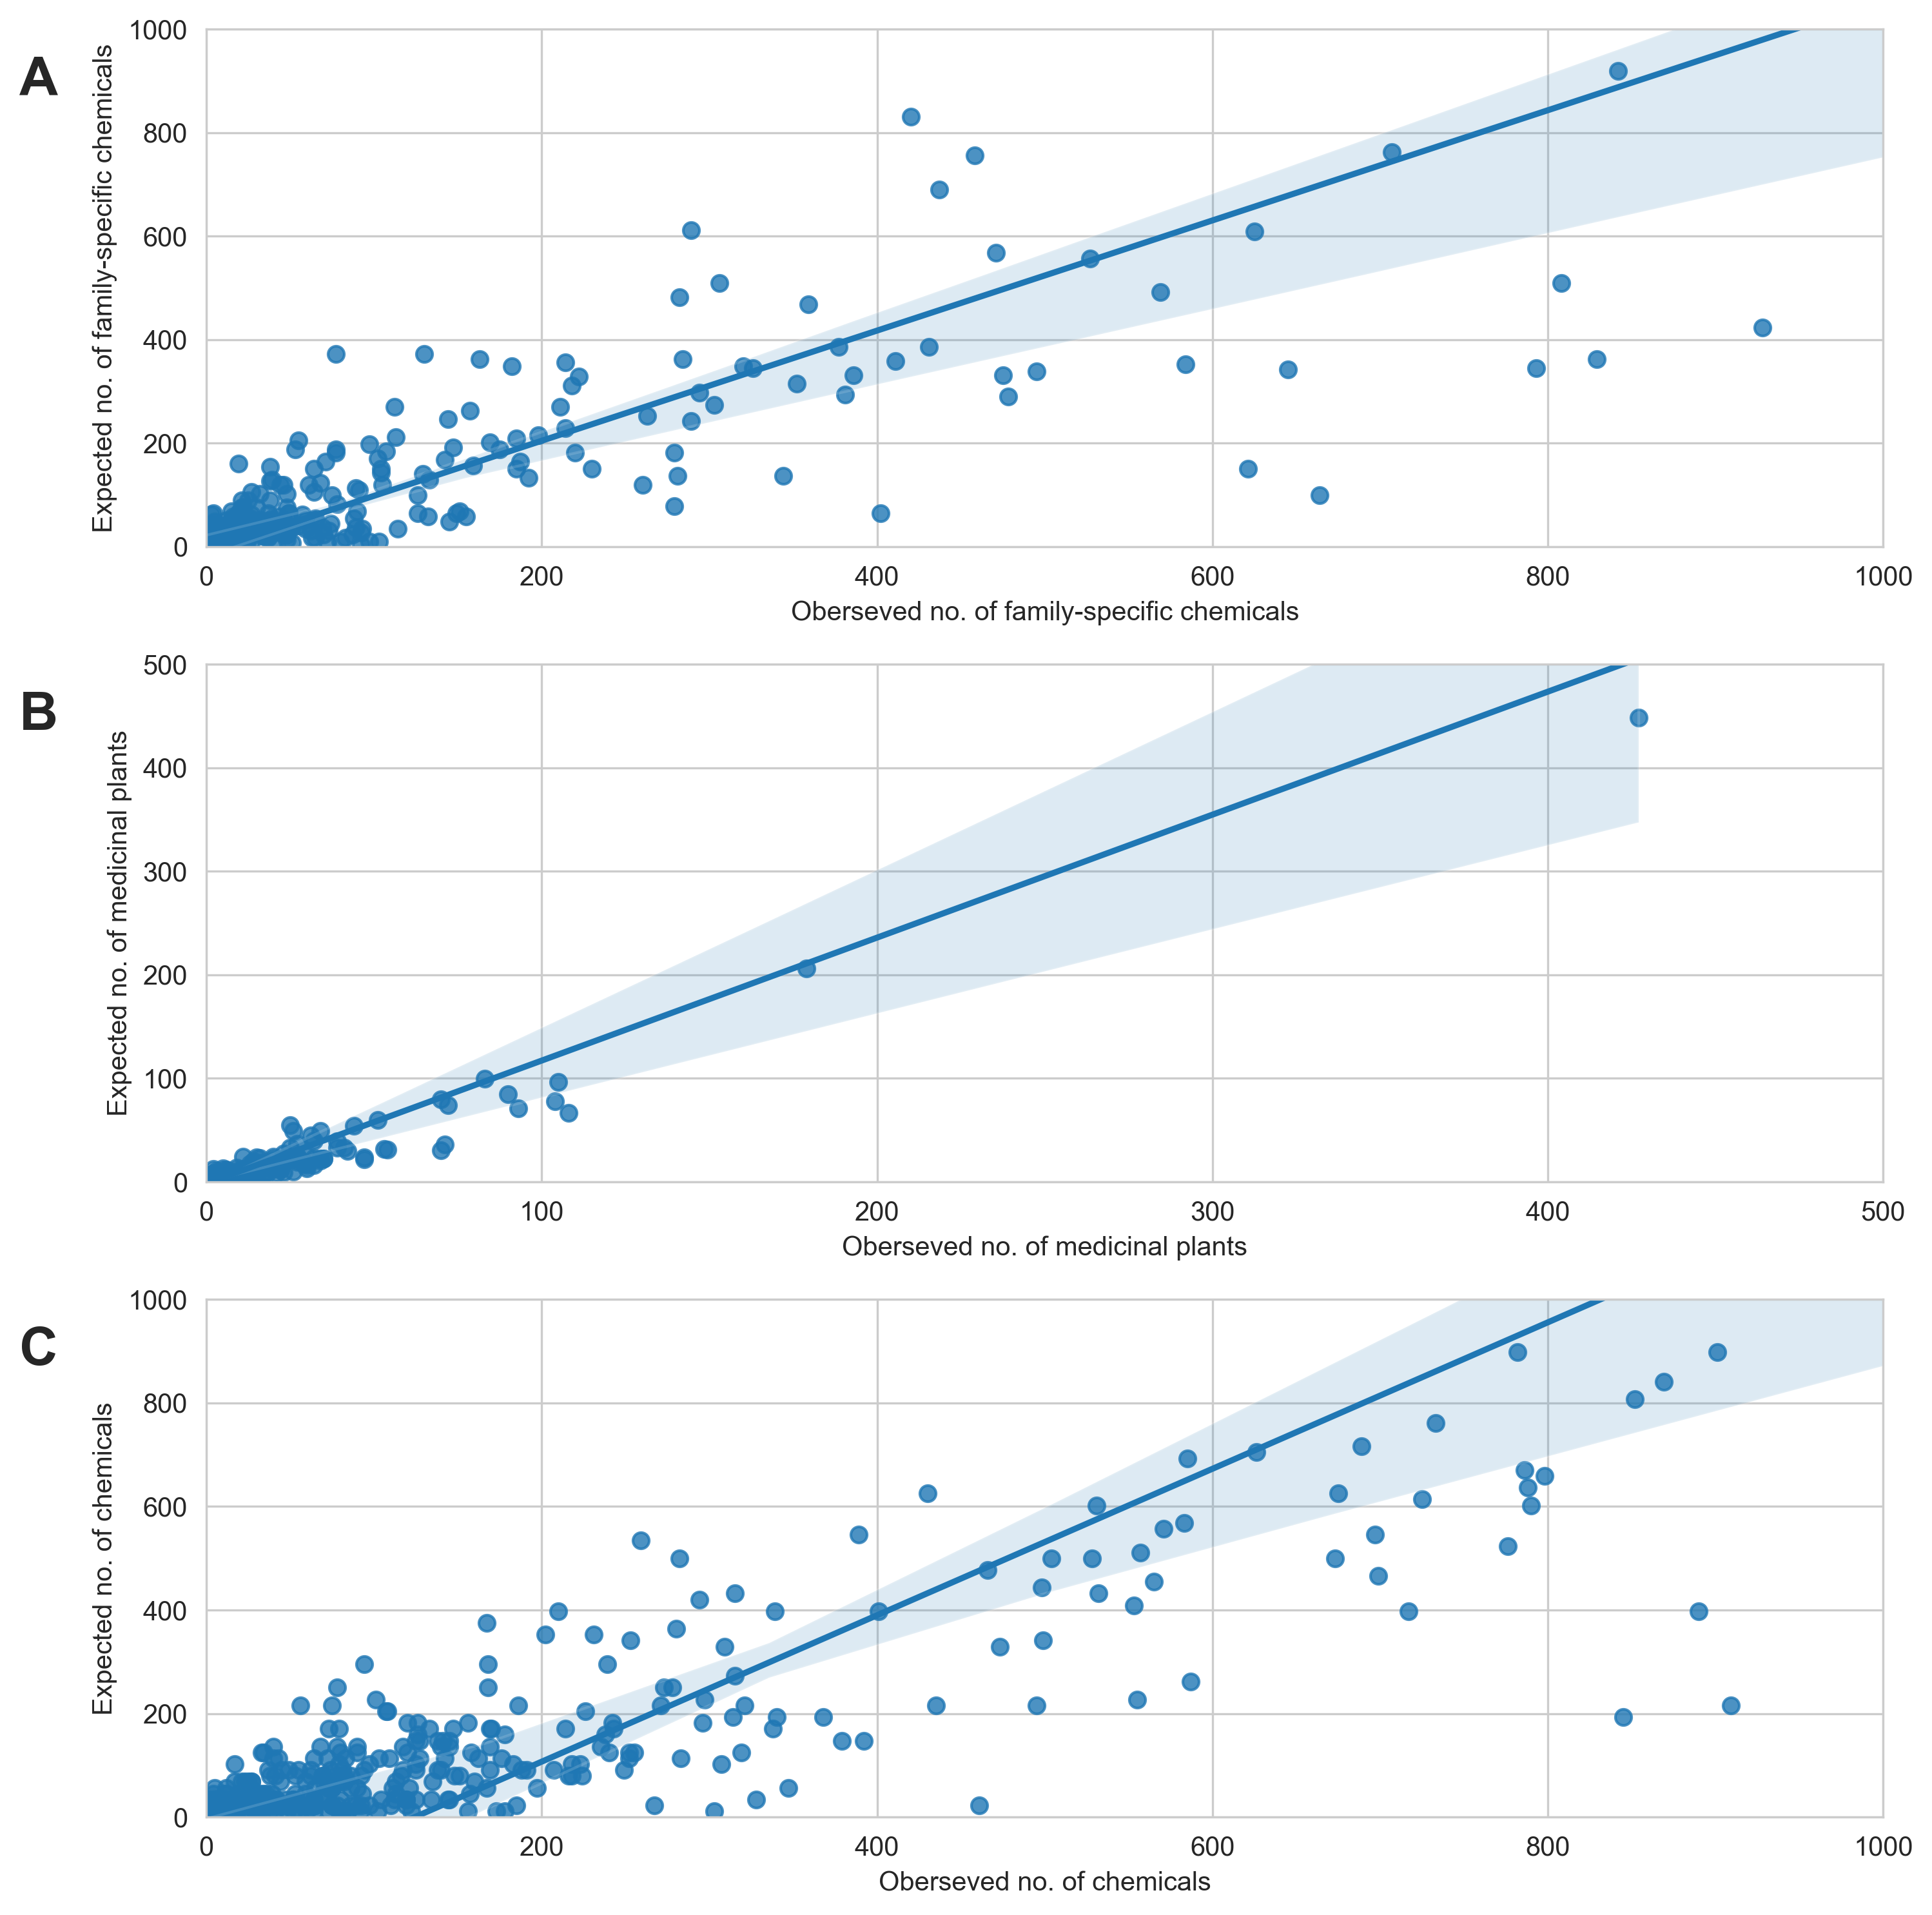

In [30]:
plt.figure(dpi=300, figsize=([10,10]))

plt.subplots_adjust(wspace=0)

plt.subplot(3,1,1)
r1 = sns.regplot(family_df, x='# family specific chemicals', y='expected_specific_chemicals')
plt.xlabel('Oberseved no. of family-specific chemicals')
plt.ylabel('Expected no. of family-specific chemicals')
plt.xlim(0, 1000)
plt.ylim(0, 1000)
plt.text(-0.1, 0.9, string.ascii_uppercase[0],  
        size=20, weight='bold', horizontalalignment='center',
        verticalalignment='center',
        transform = plt.gca().transAxes)

plt.subplot(3,1,2)
r2 = sns.regplot(family_df, x='# med plants', y='expected_medicinal_plants')
plt.xlabel('Oberseved no. of medicinal plants')
plt.ylabel('Expected no. of medicinal plants')
plt.xlim(0, 500)
plt.ylim(0, 500)
plt.text(-0.1, 0.9, string.ascii_uppercase[1],  
        size=20, weight='bold', horizontalalignment='center',
        verticalalignment='center',
        transform = plt.gca().transAxes)

plt.subplot(3,1,3)
r3 = sns.regplot(family_df, x='# chemicals', y='expected_chemicals')
plt.xlabel('Oberseved no. of chemicals')
plt.ylabel('Expected no. of chemicals')
plt.xlim(0, 1000)
plt.ylim(0, 1000)
plt.text(-0.1, 0.9, string.ascii_uppercase[2],  
        size=20, weight='bold', horizontalalignment='center',
        verticalalignment='center',
        transform = plt.gca().transAxes)

plt.tight_layout()
plt.savefig('../data/figures/supplementary_figure_1.png', bbox_inches='tight')
plt.show()